# dEdx fit

In [1]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 16

from readdata import get_data
from tpcplot import draw_g4xyz
from tracklen import process_track, plot_dedx
from recoclusters import digits_to_clusters, pixid2position

In [2]:
data_path = 'tracks'

In [3]:
trkfilter = json.load(open('trkfilter.json', 'r'))
trkfilter.keys()

dict_keys(['mu_100.0', 'mu_150.0', 'mu_200.0', 'mu_250.0', 'mu_300.0', 'mu_400.0', 'mu_500.0', 'mu_600.0', 'mu_1500.0', 'pi_100.0', 'pi_150.0', 'pi_200.0', 'pi_250.0', 'pi_300.0', 'pi_400.0', 'pi_500.0', 'pi_600.0', 'pi_1500.0', 'e_100.0', 'e_150.0', 'e_200.0', 'e_250.0', 'e_300.0', 'e_400.0', 'e_500.0', 'e_600.0', 'e_1500.0', 'K_150.0', 'K_200.0', 'K_250.0', 'K_300.0', 'K_400.0', 'K_500.0', 'K_600.0', 'K_1500.0', 'p_250.0', 'p_300.0', 'p_400.0', 'p_500.0', 'p_600.0', 'p_1500.0'])

In [4]:
def get_keys(files):
    return [os.path.splitext(os.path.split(item)[-1])[0] for item in files]

In [5]:
files = sorted(glob.glob(f'{data_path}/*.npy'))
keys = get_keys(files)
data = {key: fname for key, fname in zip(keys, files)}
', '.join(data.keys())

'K_100.0, K_150.0, K_1500.0, K_200.0, K_250.0, K_300.0, K_400.0, K_500.0, K_600.0, e_100.0, e_150.0, e_1500.0, e_200.0, e_250.0, e_300.0, e_400.0, e_500.0, e_600.0, mu_100.0, mu_150.0, mu_1500.0, mu_200.0, mu_250.0, mu_300.0, mu_400.0, mu_500.0, mu_600.0, p_1500.0, p_250.0, p_300.0, p_400.0, p_500.0, p_600.0, pi_100.0, pi_150.0, pi_1500.0, pi_200.0, pi_250.0, pi_300.0, pi_400.0, pi_500.0, pi_600.0'

In [6]:
def apply_filter(ds, cuts):
    (llo, lhi), (elo, ehi) = cuts
    return ds[(ds[:, 1] < lhi) & (ds[:, 1] > llo) & (ds[:, 2] < ehi) & (ds[:, 2] > elo)]

In [7]:
key = 'mu_1500.0'
ds = apply_filter(np.load(data[key]), trkfilter[key])[:, 2]

In [8]:
from scipy.stats import moyal

In [9]:
pdf = moyal()
x0, s0 = moyal.fit(ds)
x0, s0

(0.21488528387796985, 0.026019481506116843)

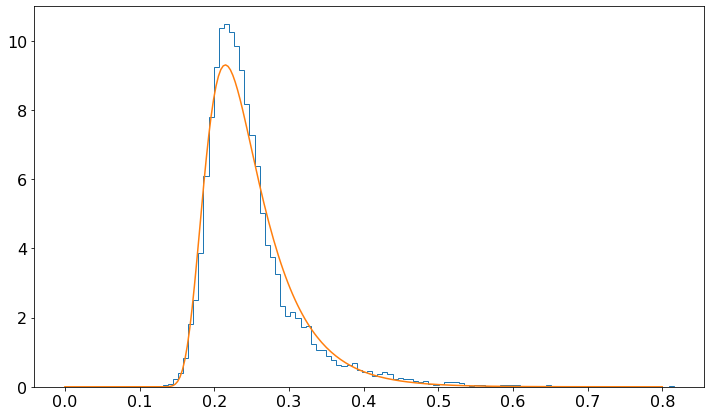

In [10]:
x = np.linspace(0, 0.8, 250)
y = moyal.pdf(x, x0, s0)
plt.figure(figsize=(12, 7))
plt.hist(ds, bins=100, density=True, histtype='step')
plt.plot(x, y);

In [11]:
def landau(x, x0, xi):
    lam = (x - x0) / xi
    return np.exp(-0.5 * (lam + np.exp(-lam))) / np.sqrt(2.*np.pi)

In [12]:
from scipy.integrate import quad

In [13]:
def norm_landau(x, *pars):
    norm = quad(lambda z: landau(z, *pars), 0.1, 0.7)[0]
    return landau(x, *pars) / norm

In [14]:
def loglh(pars):
    x0, xi = pars
    return -2. * np.log(norm_landau(ds, x0, xi)).sum()

In [15]:
from scipy.optimize import minimize

In [16]:
fitres = minimize(loglh, [0.213, 0.022], bounds=[(0.180, 0.240), (0.010, 0.072)])
fitres

      fun: -28102.720283745708
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.02364686, 0.00291038])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([0.21489737, 0.02602809])

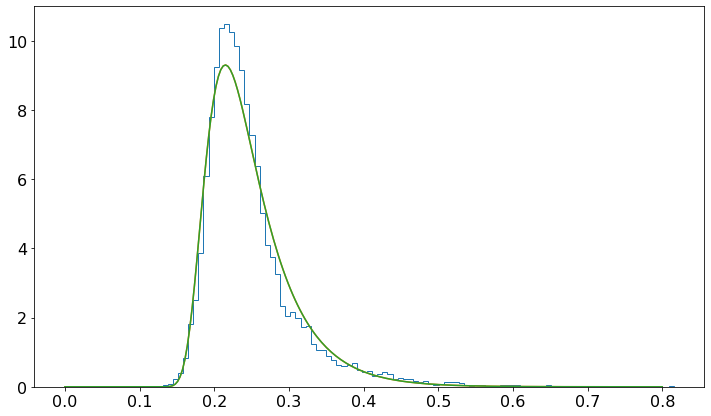

In [17]:
x = np.linspace(0, 0.8, 250)
plt.figure(figsize=(12, 7))
plt.hist(ds, bins=100, density=True, histtype='step')
plt.plot(x, moyal.pdf(x, x0, s0));
plt.plot(x, norm_landau(x, *fitres.x));

In [20]:
fitpars = {}

In [21]:
for key in keys:
    if key in trkfilter:
        ds = apply_filter(np.load(data[key]), trkfilter[key])[:, 2]
        fitpars[key] = moyal.fit(ds)
fitpars

/home/vitaly/miniconda3/envs/nsu/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1833: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


{'K_150.0': (4.465125901935648, 0.7046724994200976),
 'K_1500.0': (0.19491213963874277, 0.025680191436338817),
 'K_200.0': (1.2024013603298473, 0.11925763282534349),
 'K_250.0': (0.719589218747545, 0.1431031851712194),
 'K_300.0': (0.5523849790973392, 0.08677344435008885),
 'K_400.0': (0.3811993519311433, 0.05112421794182856),
 'K_500.0': (0.30563753281217043, 0.03896789083463954),
 'K_600.0': (0.2629284064857309, 0.03353878461212732),
 'e_100.0': (0.2745725121541537, 0.029762164533897278),
 'e_150.0': (0.2780285195581739, 0.0290816076338345),
 'e_1500.0': (0.2889786465744932, 0.027207936740136166),
 'e_200.0': (0.2800671738775171, 0.027850309843603184),
 'e_250.0': (0.28178489185531713, 0.02766076553530386),
 'e_300.0': (0.2835279655809476, 0.027852411486743014),
 'e_400.0': (0.2844712140621673, 0.02751523205285935),
 'e_500.0': (0.28536408622496806, 0.029114281657708782),
 'e_600.0': (0.28577134123836134, 0.027745850546924307),
 'mu_100.0': (0.3395154072079116, 0.03834898189262226),
